# Pre Game Predictive Analysis

This notebook details the first stage of this project. This involves predictive analysis of the IPL data set using pre match features. The data used is from the `matches` dataset which has been cleaned in the Data Analysis section. One hot encoding, labelled encoding, standardisation and normalisation are all used to improve the accuracy of the binary classifier which predicts whether there will be a home win or an away win.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, GaussianNB, CategoricalNB, ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest, chi2

In [2]:
df = pd.read_csv('cleaned_data.csv')

In [3]:
df

,Unnamed: 0,id,city,date,venue,neutral_venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,year,country
0,0,335982,Bangalore,2008-04-18,M Chinnaswamy Stadium,0,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,2008,India
1,1,335983,Chandigarh,2008-04-19,"Punjab Cricket Association Stadium, Mohali",0,Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,2008,India
2,2,335984,Delhi,2008-04-19,Feroz Shah Kotla,0,Delhi Capitals,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals,wickets,9.0,2008,India
3,3,335985,Mumbai,2008-04-20,Wankhede Stadium,0,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,2008,India
4,4,335986,Kolkata,2008-04-20,Eden Gardens,0,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,2008,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,810,1216546,Dubai,2020-10-20,Dubai International Cricket Stadium,0,Delhi Capitals,Kings XI Punjab,Delhi Capitals,bat,Kings XI Punjab,wickets,5.0,2020,UAE
776,812,1237177,Dubai,2020-11-05,Dubai International Cricket Stadium,0,Mumbai Indians,Delhi Capitals,Delhi Capitals,field,Mumbai Indians,runs,57.0,2020,UAE
777,813,1237178,Abu Dhabi,2020-11-06,Sheikh Zayed Stadium,0,Royal Challengers Bangalore,Sunrisers Hyderabad,Sunrisers Hyderabad,field,Sunrisers Hyderabad,wickets,6.0,2020,UAE
778,814,1237180,Abu Dhabi,2020-11-08,Sheikh Zayed Stadium,0,Delhi Capitals,Sunrisers Hyderabad,Delhi Capitals,bat,Delhi Capitals,runs,17.0,2020,UAE


This data set contains data for 780 games within the IPL with no result, D/L affected games and tied games removed.

The data is now prepared for the predicitive analysis. Result and result_margin are dropped as columns since these directly explain the winner.

In [4]:
df.drop(['Unnamed: 0', 'result', 'result_margin'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             780 non-null    int64 
 1   city           780 non-null    object
 2   date           780 non-null    object
 3   venue          780 non-null    object
 4   neutral_venue  780 non-null    int64 
 5   team1          780 non-null    object
 6   team2          780 non-null    object
 7   toss_winner    780 non-null    object
 8   toss_decision  780 non-null    object
 9   winner         780 non-null    object
 10  year           780 non-null    int64 
 11  country        780 non-null    object
dtypes: int64(3), object(9)
memory usage: 73.2+ KB


The columns home_won_toss and home_win are created. home_win will be used as the target label.

In [6]:
df['home_won_toss'] = np.where(df.toss_winner == df.team1, 1, 0)
df['home_win'] = np.where(df.team1 == df.winner, 1, 0)

## Label encoding

Some of the algorithms are distance based and therefore we need to change our categorical variables such as team names into a label encoded numerical value so that they can be used in these algorithms.

In [7]:
le = preprocessing.LabelEncoder()

In [8]:
le.fit(df['city'])
df['city'] = le.transform(df['city'])

le.fit(df['venue'])
df['venue'] = le.transform(df['venue'])

le.fit(df['team1'])
df['team1'] = le.transform(df['team1'])

le.fit(df['team2'])
df['team2'] = le.transform(df['team2'])

le.fit(df['toss_decision'])
df['toss_decision'] = le.transform(df['toss_decision'])

le.fit(df['country'])
df['country'] = le.transform(df['country'])

le.fit(df['date'])
df['date'] = le.transform(df['date'])

In [9]:
df.drop(['toss_winner'], axis=1, inplace=True)

In [10]:
df

,id,city,date,venue,neutral_venue,team1,team2,toss_decision,winner,year,country,home_won_toss,home_win
0,335982,2,0,14,0,11,6,1,Kolkata Knight Riders,2008,0,1,0
1,335983,7,1,23,0,4,0,0,Chennai Super Kings,2008,0,0,0
2,335984,10,1,8,0,2,9,0,Delhi Capitals,2008,0,0,1
3,335985,23,2,35,0,7,11,0,Royal Challengers Bangalore,2008,0,1,0
4,335986,22,2,7,0,6,1,0,Kolkata Knight Riders,2008,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,1216546,12,560,6,0,2,4,0,Kings XI Punjab,2020,2,1,0
776,1237177,12,575,6,0,7,2,1,Mumbai Indians,2020,2,0,1
777,1237178,0,576,30,0,11,12,1,Sunrisers Hyderabad,2020,2,0,0
778,1237180,0,577,30,0,2,12,0,Delhi Capitals,2020,2,1,1


In [11]:
df.to_csv('encoded_matches.csv')
df.drop(['id'], axis=1, inplace=True)

Text(0.5, 1.0, 'Correlation between features')

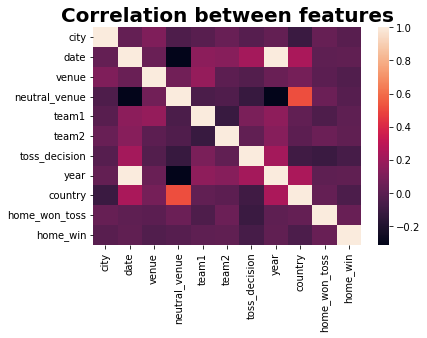

In [12]:
sns.heatmap(df.corr())
plt.title('Correlation between features',size=20,fontweight="bold")

## Labels and train/test data

The data is split into a set for training and a set for testing. The target label home_win is also specified and split into a training and test set. Before this is done we can drop winner and home_win from the main dataframe as this would interfere with the predictions otherwise.

In [13]:
y = df.home_win
df.drop(['winner', 'home_win'], axis=1, inplace=True)

In [14]:
df

,city,date,venue,neutral_venue,team1,team2,toss_decision,year,country,home_won_toss
0,2,0,14,0,11,6,1,2008,0,1
1,7,1,23,0,4,0,0,2008,0,0
2,10,1,8,0,2,9,0,2008,0,0
3,23,2,35,0,7,11,0,2008,0,1
4,22,2,7,0,6,1,0,2008,0,0
...,...,...,...,...,...,...,...,...,...,...
775,12,560,6,0,2,4,0,2020,2,1
776,12,575,6,0,7,2,1,2020,2,0
777,0,576,30,0,11,12,1,2020,2,0
778,0,577,30,0,2,12,0,2020,2,1


## Pre game predictions

A function will be created to minimise the reuse of code for each of the algorithms we are to use. The selected algorithms are:

- Random Forest
- Logistic Regression
- Support Vector Machine
- Naive Bayes
- XGBoost

In [15]:
def get_prediction(model, df, y):
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
    clf = model
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Classification report : \n \n", classification_report(y_test,y_pred))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    print("AUC : ", auc)

## Random Forest

In [16]:
get_prediction(RandomForestClassifier(max_depth=1, random_state=0), df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.58      0.13      0.21        55
           1       0.67      0.95      0.78       101

    accuracy                           0.66       156
   macro avg       0.62      0.54      0.50       156
weighted avg       0.64      0.66      0.58       156

AUC :  0.5388838883888389


## Logistic Regression

In [17]:
get_prediction(LogisticRegression(random_state=0, max_iter=3000), df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.25      0.24      0.24        55
           1       0.59      0.60      0.60       101

    accuracy                           0.47       156
   macro avg       0.42      0.42      0.42       156
weighted avg       0.47      0.47      0.47       156

AUC :  0.4201620162016202


## Support Vector Machine

In [18]:
get_prediction(SVC(gamma='auto'), df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.28      0.15      0.19        55
           1       0.63      0.79      0.70       101

    accuracy                           0.56       156
   macro avg       0.45      0.47      0.45       156
weighted avg       0.51      0.56      0.52       156

AUC :  0.4687668766876688


## Naive bayes

In [19]:
get_prediction(CategoricalNB(), df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.46      0.67      0.54        55
           1       0.76      0.56      0.65       101

    accuracy                           0.60       156
   macro avg       0.61      0.62      0.60       156
weighted avg       0.65      0.60      0.61       156

AUC :  0.6185418541854185


## XGBoost

In [20]:
get_prediction(xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.38      0.55      0.44        55
           1       0.67      0.50      0.58       101

    accuracy                           0.52       156
   macro avg       0.52      0.53      0.51       156
weighted avg       0.57      0.52      0.53       156

AUC :  0.5252025202520252


## Feature Selection

The features within the data frame are inspected to determine which have the most influence on the prediction. This is done using sklearns SelectFromModel. All algorithms are used to show how the choice of algorithm results in varying importance across features.

In [21]:
from sklearn.feature_selection import SelectFromModel

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)
X_train.shape


(624, 10)

## Random Forest feature selection

In [23]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = clf.fit(X_train, y_train)
clf.feature_importances_

array([0.12208751, 0.26478486, 0.16027685, 0.01661105, 0.14689851,
       0.07498305, 0.07895493, 0.08835919, 0.01135894, 0.03568511])

In [24]:
d = {}
l = list(X_train)
longest = max(l, key=len)
for i in range(len(l)):
    d[l[i]]=round(clf.feature_importances_[i], 3)
    diff = len(longest) - (len(l[i]))
    pack = ' '* diff
    print(l[i] + pack, round(clf.feature_importances_[i], 3))
    
d=dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

city          0.122
date          0.265
venue         0.16
neutral_venue 0.017
team1         0.147
team2         0.075
toss_decision 0.079
year          0.088
country       0.011
home_won_toss 0.036


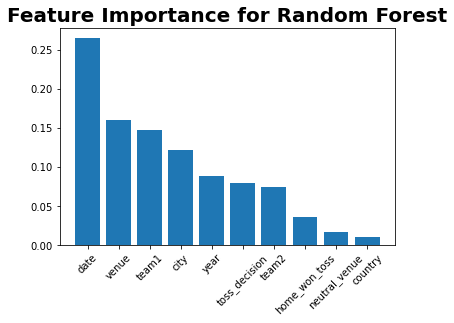

In [25]:
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()), rotation=45)
plt.title('Feature Importance for Random Forest',size=20,fontweight="bold")
plt.show()

In [26]:
model = SelectFromModel(clf)
model.fit(X_train, y_train)
feature_idx = model.get_support()
feature_name = df.columns[feature_idx]
feature_name

Index(['city', 'date', 'venue', 'team1'], dtype='object')

In [27]:
feature_name

Index(['city', 'date', 'venue', 'team1'], dtype='object')

In [28]:
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)

In [29]:
X_new.shape

(624, 4)

In [30]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
clf = clf.fit(X_new, y_train)
y_pred = clf.predict(X_test_new)

In [31]:
print("Classification report : \n \n", classification_report(y_test,y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("AUC : ", auc)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.41      0.53      0.46        55
           1       0.70      0.59      0.64       101

    accuracy                           0.57       156
   macro avg       0.56      0.56      0.55       156
weighted avg       0.60      0.57      0.58       156

AUC :  0.5606660666066607


## Logistic regression feature selection

In [32]:
clf = LogisticRegression(random_state=0, max_iter=3000)
clf = clf.fit(X_train, y_train)
clf.coef_

array([[-5.54813989e-03,  8.04190223e-04, -1.22689645e-02,
        -6.93068095e-02,  3.47615368e-02,  2.51216344e-02,
        -3.76523304e-01, -4.40073806e-06, -2.63960197e-01,
         2.72821102e-01]])

In [33]:
d = {}
l = list(X_train)
longest = max(l, key=len)
for i in range(len(l)):
    d[l[i]]=round(np.abs(clf.coef_[0][i]), 3)
    diff = len(longest) - (len(l[i]))
    pack = ' '* diff
    print(l[i] + pack, round(np.abs(clf.coef_[0][i]), 3))
    
d=dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

city          0.006
date          0.001
venue         0.012
neutral_venue 0.069
team1         0.035
team2         0.025
toss_decision 0.377
year          0.0
country       0.264
home_won_toss 0.273


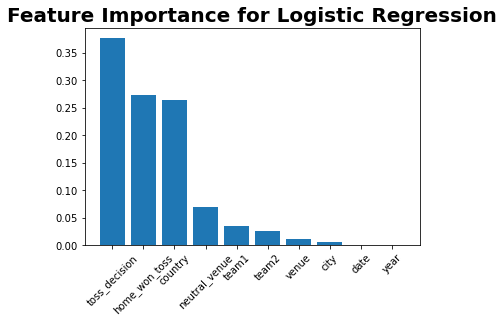

In [34]:
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()), rotation=45)
plt.title('Feature Importance for Logistic Regression',size=20,fontweight="bold")
plt.show()

In [35]:
model = SelectFromModel(clf)
model.fit(X_train, y_train)
feature_idx = model.get_support()
feature_name = df.columns[feature_idx]
feature_name

Index(['toss_decision', 'country', 'home_won_toss'], dtype='object')

In [36]:
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)
X_test_new.shape

(156, 3)

In [37]:
clf = LogisticRegression(random_state=0, max_iter=3000)
clf = clf.fit(X_new, y_train)
y_pred = clf.predict(X_test_new)

In [38]:

print("Classification report : \n \n", classification_report(y_test,y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("AUC : ", auc)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.36      0.29      0.32        55
           1       0.65      0.71      0.68       101

    accuracy                           0.56       156
   macro avg       0.50      0.50      0.50       156
weighted avg       0.55      0.56      0.55       156

AUC :  0.5018901890189018


## Logistic regression feature selection with standardisation

The random forest is a decision based classifier and so it deals well with large difference in variance across values in seperate columns. The logistic regression classifier may perform better with standardised data and this may also influence the feature selection process.

In [39]:
scaler = StandardScaler().fit(X_train)

In [40]:
X_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [41]:
clf = LogisticRegression(random_state=0, max_iter=3000)
clf = clf.fit(X_scaled, y_train)
clf.coef_

array([[-0.04507472,  0.05543065, -0.12797326,  0.01478094,  0.13261027,
         0.0943295 , -0.21568609,  0.09564369, -0.1666369 ,  0.12278359]])

city          0.045
date          0.055
venue         0.128
neutral_venue 0.015
team1         0.133
team2         0.094
toss_decision 0.216
year          0.096
country       0.167
home_won_toss 0.123


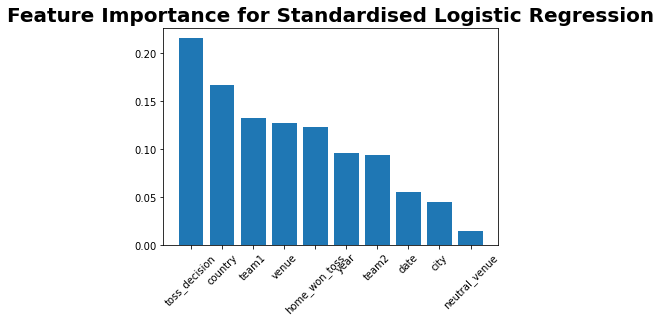

In [42]:
d = {}
l = list(X_train)
longest = max(l, key=len)
for i in range(len(l)):
    d[l[i]]=round(np.abs(clf.coef_[0][i]), 3)
    diff = len(longest) - (len(l[i]))
    pack = ' '* diff
    print(l[i] + pack, round(np.abs(clf.coef_[0][i]), 3))
    
d=dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()), rotation=45)
plt.title('Feature Importance for Standardised Logistic Regression',size=20,fontweight="bold")
plt.show()

In [43]:
model = SelectFromModel(clf)
model.fit(X_scaled, y_train)
feature_idx = model.get_support()
feature_name = df.columns[feature_idx]

In [44]:
feature_name

Index(['venue', 'team1', 'toss_decision', 'country', 'home_won_toss'], dtype='object')

In [45]:
X_new = model.transform(X_scaled)
X_test_new = model.transform(X_test_scaled)
X_test_new.shape

(156, 5)

In [46]:
clf = LogisticRegression(random_state=0, max_iter=3000)
clf = clf.fit(X_new, y_train)
y_pred = clf.predict(X_test_new)

In [47]:
print("Classification report : \n \n", classification_report(y_test,y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("AUC : ", auc)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.30      0.27      0.29        55
           1       0.62      0.65      0.64       101

    accuracy                           0.52       156
   macro avg       0.46      0.46      0.46       156
weighted avg       0.51      0.52      0.51       156

AUC :  0.46309630963096315


## XGBoost feature selection

In [48]:
clf = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
clf = clf.fit(X_scaled, y_train)
clf.feature_importances_

array([0.10843381, 0.10712001, 0.10457242, 0.14457428, 0.11215251,
       0.09290227, 0.14262712, 0.        , 0.10434441, 0.08327316],
      dtype=float32)

In [49]:
d = {}
l = list(X_train)
longest = max(l, key=len)
for i in range(len(l)):
    d[l[i]]=round(clf.feature_importances_[i], 3)
    diff = len(longest) - (len(l[i]))
    pack = ' '* diff
    print(l[i] + pack, round(clf.feature_importances_[i], 3))
    
d=dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

city          0.108
date          0.107
venue         0.105
neutral_venue 0.145
team1         0.112
team2         0.093
toss_decision 0.143
year          0.0
country       0.104
home_won_toss 0.083


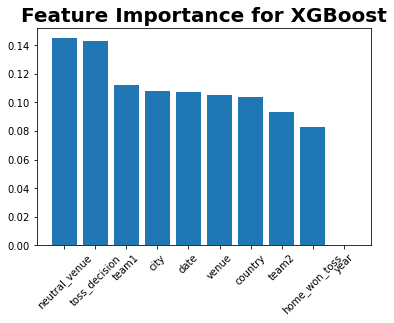

In [50]:
plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()), rotation=45)
plt.title('Feature Importance for XGBoost',size=20,fontweight="bold")
plt.show()

In [51]:
model = SelectFromModel(clf)
model.fit(X_train, y_train)
feature_idx = model.get_support()
feature_name = df.columns[feature_idx]
feature_name

Index(['city', 'date', 'venue', 'neutral_venue', 'team1', 'toss_decision',
       'country'],
      dtype='object')

In [52]:
X_new = model.transform(X_train)
X_test_new = model.transform(X_test)
X_new.shape

(624, 7)

In [53]:
clf = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
clf = clf.fit(X_new, y_train)
y_pred = clf.predict(X_test_new)
print("Classification report : \n \n", classification_report(y_test,y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("AUC : ", auc)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.39      0.62      0.48        55
           1       0.69      0.47      0.56       101

    accuracy                           0.52       156
   macro avg       0.54      0.54      0.52       156
weighted avg       0.58      0.52      0.53       156

AUC :  0.5417641764176417


## Support vector machine feature selection 


In [54]:
clf = SVC(gamma='auto', kernel='linear')
clf = clf.fit(X_train, y_train)
clf.coef_

array([[-0.00747945, -0.0044036 , -0.02809404,  0.17311017,  0.06565632,
         0.04711975, -0.78689024,  0.28634699, -0.50807478,  0.47002044]])

In [55]:
imps = permutation_importance(clf, X_train, y_train)
imps.importances_mean

array([-0.00128205,  0.0349359 ,  0.02532051, -0.00128205,  0.02019231,
        0.00448718,  0.03173077,  0.04615385,  0.01185897,  0.02179487])

city          0.007
date          0.004
venue         0.028
neutral_venue 0.173
team1         0.066
team2         0.047
toss_decision 0.787
year          0.286
country       0.508
home_won_toss 0.47


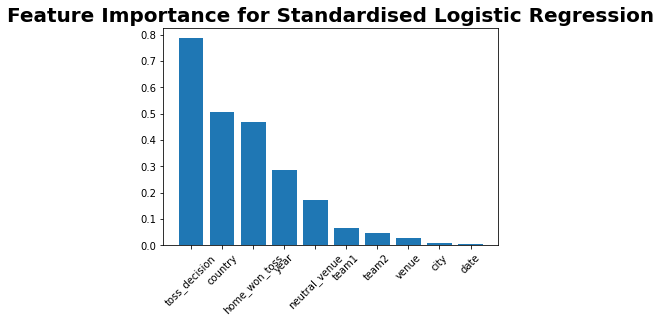

(624, 5)
Classification report : 
 
               precision    recall  f1-score   support

           0       0.35      0.31      0.33        55
           1       0.64      0.68      0.66       101

    accuracy                           0.55       156
   macro avg       0.50      0.50      0.50       156
weighted avg       0.54      0.55      0.54       156

AUC :  0.4961296129612962


In [56]:
d = {}
l = list(X_train)
longest = max(l, key=len)
for i in range(len(l)):
    d[l[i]]=round(np.abs(clf.coef_[0][i]), 3)
    diff = len(longest) - (len(l[i]))
    pack = ' '* diff
    print(l[i] + pack, round(np.abs(clf.coef_[0][i]), 3))
    
d=dict(sorted(d.items(), key=lambda item: item[1], reverse=True))

plt.bar(range(len(d)), list(d.values()), align='center')
plt.xticks(range(len(d)), list(d.keys()), rotation=45)
plt.title('Feature Importance for Standardised Logistic Regression',size=20,fontweight="bold")
plt.show()

X_new = SelectKBest(chi2, k=5).fit_transform(X_train, y_train)
X_test_new = SelectKBest(chi2, k=5).fit_transform(X_test, y_test)
print(X_new.shape)

clf = SVC(gamma='auto', kernel='linear')
clf = clf.fit(X_new, y_train)
y_pred = clf.predict(X_test_new)
print("Classification report : \n \n", classification_report(y_test,y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("AUC : ", auc)

## Naïve bayes feature selection

In [57]:
clf = GaussianNB()
clf = clf.fit(X_train, y_train)

In [58]:
imps = permutation_importance(clf, X_train, y_train)
imps.importances_mean

array([ 3.20512821e-03, -7.05128205e-03, -4.80769231e-03,  6.41025641e-04,
        6.73076923e-03,  1.92307692e-03,  4.44089210e-17, -4.48717949e-03,
        1.28205128e-02, -5.12820513e-03])

In [59]:
X_new = SelectKBest(chi2, k=7).fit_transform(X_train, y_train)
X_test_new = SelectKBest(chi2, k=7).fit_transform(X_test, y_test)
print(X_new.shape)

(624, 7)


In [60]:
clf = GaussianNB()
clf = clf.fit(X_new, y_train)
y_pred = clf.predict(X_test_new)

In [61]:
print("Classification report : \n \n", classification_report(y_test,y_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print("AUC : ", auc)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.32      0.13      0.18        55
           1       0.64      0.85      0.73       101

    accuracy                           0.60       156
   macro avg       0.48      0.49      0.46       156
weighted avg       0.53      0.60      0.54       156

AUC :  0.4893789378937894


## One Hot Encoding

The categorical data in this data set has been label encoded into numbers which represent each of the various categories within each feature. Label encoding is one of two methods to convert categorical data into numerical data. The second method available to us is One Hot Encoding (OHE). Label encoding may result in the model learning incorrect information about the data due to the variety of values. If one column contains 10 unique entries for each team, these will be transformed into 0-10 values but the model may attribute more weight to 10 than to 0 even when all teams are equal. This is where OHE can be of use. This transforms the data into a column for every unique value within a single column (i.e team1). This increases the size of the dataset but can aid the model. For this dataset the team1 and team2 will be converted (OHE) into appropriate columns to try improve upon the results so far.

In [62]:
df

,city,date,venue,neutral_venue,team1,team2,toss_decision,year,country,home_won_toss
0,2,0,14,0,11,6,1,2008,0,1
1,7,1,23,0,4,0,0,2008,0,0
2,10,1,8,0,2,9,0,2008,0,0
3,23,2,35,0,7,11,0,2008,0,1
4,22,2,7,0,6,1,0,2008,0,0
...,...,...,...,...,...,...,...,...,...,...
775,12,560,6,0,2,4,0,2020,2,1
776,12,575,6,0,7,2,1,2020,2,0
777,0,576,30,0,11,12,1,2020,2,0
778,0,577,30,0,2,12,0,2020,2,1


In [63]:
enc = OneHotEncoder(handle_unknown='ignore')

In [64]:
enc_df = pd.DataFrame(enc.fit_transform(df[['team1']]).toarray())
enc_df2 = pd.DataFrame(enc.fit_transform(df[['team2']]).toarray())

In [65]:
enc_df = enc_df.rename(columns={0: 'Chennai Super Kings', 1: 'Deccan Chargers', 2: 'Delhi Capitals', 3: 'Gujarat Lions', 4: 'Kings XI Punjab', 5: 'Kochi Tuskers Kerala', 6: 'Kolkata Knight Riders', 7: 'Mumbai Indians', 8: 'Pune Warriors', 9: 'Rajasthan Royals', 10: 'Rising Pune Supergiant', 11: 'Royal Challengers Bangalore', 12: 'Sunrisers Hyderabad'})
enc_df2 = enc_df2.rename(columns={0: 'Chennai Super KingsA', 1: 'Deccan ChargersA', 2: 'Delhi CapitalsA', 3: 'Gujarat LionsA', 4: 'Kings XI PunjabA', 5: 'Kochi Tuskers KeralaA', 6: 'Kolkata Knight RidersA', 7: 'Mumbai IndiansA', 8: 'Pune WarriorsA', 9: 'Rajasthan RoyalsA', 10: 'Rising Pune SupergiantA', 11: 'Royal Challengers BangaloreA', 12: 'Sunrisers HyderabadA'})


In [66]:
df.reset_index(inplace=True)
enc = pd.concat([df, enc_df], axis=1)
enc = pd.concat([enc, enc_df2], axis=1)
enc

,index,city,date,venue,neutral_venue,team1,team2,toss_decision,year,country,...,Gujarat LionsA,Kings XI PunjabA,Kochi Tuskers KeralaA,Kolkata Knight RidersA,Mumbai IndiansA,Pune WarriorsA,Rajasthan RoyalsA,Rising Pune SupergiantA,Royal Challengers BangaloreA,Sunrisers HyderabadA
0,0,2,0,14,0,11,6,1,2008,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,7,1,23,0,4,0,0,2008,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,10,1,8,0,2,9,0,2008,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,23,2,35,0,7,11,0,2008,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4,22,2,7,0,6,1,0,2008,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,775,12,560,6,0,2,4,0,2020,2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,776,12,575,6,0,7,2,1,2020,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,777,0,576,30,0,11,12,1,2020,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
778,778,0,577,30,0,2,12,0,2020,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Random Forest

In [67]:
get_prediction(RandomForestClassifier(max_depth=2, random_state=0), enc, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.45      0.25      0.33        55
           1       0.67      0.83      0.74       101

    accuracy                           0.63       156
   macro avg       0.56      0.54      0.53       156
weighted avg       0.59      0.63      0.60       156

AUC :  0.5431143114311431


The OHE data has resulted in 36 columns for the data. This may be affecting the performance of the model and so all columns other than the OHE team values will be removed to improve the predicitve capabilities of the model.

In [68]:
enc_1 = enc
enc_1 = enc_1.drop(columns=['year','team1', 'team2', 'date', 'index','city','venue', 'toss_decision', 'country', 'home_won_toss', 'neutral_venue'])
enc_1

,Chennai Super Kings,Deccan Chargers,Delhi Capitals,Gujarat Lions,Kings XI Punjab,Kochi Tuskers Kerala,Kolkata Knight Riders,Mumbai Indians,Pune Warriors,Rajasthan Royals,...,Gujarat LionsA,Kings XI PunjabA,Kochi Tuskers KeralaA,Kolkata Knight RidersA,Mumbai IndiansA,Pune WarriorsA,Rajasthan RoyalsA,Rising Pune SupergiantA,Royal Challengers BangaloreA,Sunrisers HyderabadA
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
778,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [69]:
enc_1.to_csv('one_hot_teams_only.csv')

## Random Forest

In [70]:
get_prediction(RandomForestClassifier(max_depth=2, random_state=0), enc_1, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.52      0.29      0.37        55
           1       0.69      0.85      0.76       101

    accuracy                           0.65       156
   macro avg       0.60      0.57      0.57       156
weighted avg       0.63      0.65      0.62       156

AUC :  0.5711971197119712


## Logistic Regression

In [71]:
get_prediction(LogisticRegression(random_state=0), enc_1, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.42      0.60      0.49        55
           1       0.71      0.54      0.62       101

    accuracy                           0.56       156
   macro avg       0.57      0.57      0.56       156
weighted avg       0.61      0.56      0.57       156

AUC :  0.5722772277227722


## Naive Bayes

In [72]:
get_prediction(CategoricalNB(), enc_1, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.42      0.62      0.50        55
           1       0.72      0.54      0.62       101

    accuracy                           0.57       156
   macro avg       0.57      0.58      0.56       156
weighted avg       0.62      0.57      0.58       156

AUC :  0.5813681368136814


## Support Vector Machine

In [73]:
get_prediction(SVC(gamma='auto'), enc_1, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.39      0.47      0.43        55
           1       0.68      0.60      0.64       101

    accuracy                           0.56       156
   macro avg       0.54      0.54      0.53       156
weighted avg       0.58      0.56      0.57       156

AUC :  0.5383438343834384


## XGBoost

In [74]:
get_prediction(xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), enc_1, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.41      0.56      0.47        55
           1       0.70      0.55      0.62       101

    accuracy                           0.56       156
   macro avg       0.55      0.56      0.55       156
weighted avg       0.60      0.56      0.57       156

AUC :  0.5590459045904591


## Simple model 

Often the simplest model can be the most effective - Occam's razor states that the fewest possible entities should be used if possible - and so the single column of home team with data one hot encoded is used with a random forest classifier.


In [75]:
get_prediction(RandomForestClassifier(max_depth=2, random_state=0), enc_df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.58      0.20      0.30        55
           1       0.68      0.92      0.78       101

    accuracy                           0.67       156
   macro avg       0.63      0.56      0.54       156
weighted avg       0.64      0.67      0.61       156

AUC :  0.5603960396039604


In [76]:
get_prediction(LogisticRegression(random_state=0), enc_df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.41      0.62      0.49        55
           1       0.71      0.51      0.60       101

    accuracy                           0.55       156
   macro avg       0.56      0.57      0.55       156
weighted avg       0.61      0.55      0.56       156

AUC :  0.5665166516651665


In [77]:
get_prediction(CategoricalNB(), enc_df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.41      0.62      0.49        55
           1       0.71      0.51      0.60       101

    accuracy                           0.55       156
   macro avg       0.56      0.57      0.55       156
weighted avg       0.61      0.55      0.56       156

AUC :  0.5665166516651665


In [78]:
get_prediction(SVC(gamma='auto'), enc_df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.41      0.62      0.49        55
           1       0.71      0.51      0.60       101

    accuracy                           0.55       156
   macro avg       0.56      0.57      0.55       156
weighted avg       0.61      0.55      0.56       156

AUC :  0.5665166516651665


In [79]:
get_prediction(xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False), enc_df, y)

Classification report : 
 
               precision    recall  f1-score   support

           0       0.41      0.62      0.49        55
           1       0.71      0.51      0.60       101

    accuracy                           0.55       156
   macro avg       0.56      0.57      0.55       156
weighted avg       0.61      0.55      0.56       156

AUC :  0.5665166516651665


In [80]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Results

| Model                  |    All data columns  | with Feature Selection | with One hot encoding of teams       |
| ---------------------  | ------------- | ------------------- | ------------------- |
|Random Forest           |   **0.66**    |        0.57         |       **0.65**      |
|Logistic Regression     |     0.47      |        0.56         |       0.56          |
|Naïve Bayes             |     0.58      |      **0.60**       |       0.57          |
|Support Vector Machine  |     0.56      |        0.55         |       0.56          |
|XGBoost                 |     0.52      |        0.57         |       0.57          |

The use of feature selection improves the accuracy of naïve bayes, logistic regression and XGBoost. Support vector machine sees no improvement with feature selection. Random forest sees a reduction in accuracy with feature selection. random forest is a decision based algorithms and this may be a reason behind this.

One Hot Encoding increases the accuracy for logistic regression and XGBoost and similarly sees random forest and SVM and naïve bayes with little improvement. Interestingly the random forest classifier is most accurate when all other features are removed other than home team and away team. The final simple model uses soley the home team as a feature and achieves the highest accuracy of 67% of all the scenarios that have been run. This simple approach involves the least computation and yet returns the highest accuracy.

To further test the predictive abilities of this model the 2022 IPL games are recorded alongside the pre-game betting odds for each team. This allows us to (theoretically) inspect the accuracy of the predictive system vs a larger more complex model such as betting platforms.

In [81]:
ipl_22 = pd.read_excel('IPL_betting_odds.xlsx', sheet_name='teams')

In [82]:
ipl_22

,Chennai Super Kings,Deccan Chargers,Delhi Capitals,Gujarat Lions,Kings XI Punjab,Kochi Tuskers Kerala,Kolkata Knight Riders,Mumbai Indians,Pune Warriors,Rajasthan Royals,...,Kolkata Knight RidersA,Mumbai IndiansA,Pune WarriorsA,Rajasthan RoyalsA,Rising Pune SupergiantA,Royal Challengers BangaloreA,Sunrisers HyderabadA,team1_odds,team2_odds,team1_win
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1.91,1.80,1.0
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2.00,1.73,1.0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,2.00,1.73,1.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2.10,1.67,0.0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1.70,2.10,1.0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2.10,1.70,1.0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,1.70,2.10,0.0
7,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.60,2.20,0.0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,2.10,1.70,0.0
9,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1.90,1.90,1.0


In [83]:
ipl_22 = ipl_22[0:24]
team1_odds = ipl_22.team1_odds
team2_odds = ipl_22.team2_odds
team1_win = np.array(ipl_22.team1_win)
ipl_22 = ipl_22.drop(columns=['team1_odds', 'team2_odds', 'team1_win'])
ipl_22

,Chennai Super Kings,Deccan Chargers,Delhi Capitals,Gujarat Lions,Kings XI Punjab,Kochi Tuskers Kerala,Kolkata Knight Riders,Mumbai Indians,Pune Warriors,Rajasthan Royals,...,Gujarat LionsA,Kings XI PunjabA,Kochi Tuskers KeralaA,Kolkata Knight RidersA,Mumbai IndiansA,Pune WarriorsA,Rajasthan RoyalsA,Rising Pune SupergiantA,Royal Challengers BangaloreA,Sunrisers HyderabadA
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
7,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [84]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = clf.fit(enc_1, y)
y_pred = clf.predict(ipl_22)

In [85]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [86]:
team1_win

array([1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 0., 0., 0., 1.])

In [87]:
purse = 0
i = 0
while i < len(team1_win):
    if y_pred[i]== team1_win[i]:
        if y_pred[i]==1:
            purse += 1*team1_odds[i] - 1
        else:
            purse += 1*team2_odds[i] - 1
    else:
        purse = purse - 1
    i += 1

print('Cumulative stakes: ' + str(len(team1_win)) + '\nTotal Profit: ' + str(round(purse, 2)))

Cumulative stakes: 24
Total Profit: -2.49


## Results



The model has retured a loss of 2.49 with 24 units having been bet on this pre game prediction of the 2022 IPL. This shows there is a clear limitation to this system. The model has also predicted a home win for each and every game which shows that there is little else being learned from the data other than a home win is more likely than an away win. The other thing of note is the 2021 IPL mega auction in which most teams lost large numbers of their 2021 and historic squads which will have reduced the effectiveness of this predictor as using 2021 teams performance to predict 2022 performance is no longer as effective with a very different make up of each squad.